In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys
sys.path.append("../")

from tuneavideo.models.unet_with_controlnet import UNet2DConditionModel
from tuneavideo.data.dataset import TuneAVideoMoreShotDataset
from tuneavideo.models.unet import UNet3DConditionModel
from tuneavideo.pipelines.pipeline_tuneavideo import TuneAVideoPipeline
from tuneavideo.pipelines.pipeline_tuneavideo_controlnet import TuneAVideoControlNetPipeline

import torch
from transformers import CLIPTokenizer
import numpy as np
from einops import rearrange
from PIL import Image

In [27]:
unet = UNet3DConditionModel.from_pretrained("../checkpoints/tav_yor_dedede", subfolder='unet', torch_dtype=torch.float16)
controlnet = UNet2DConditionModel.from_pretrained("../../diffusers_controlnet/models/control_sd15_openpose/controlnet", torch_dtype=torch.float16)
tuneavideo = TuneAVideoControlNetPipeline.from_pretrained("../checkpoints/dedede", unet=unet, controlnet=controlnet, torch_dtype=torch.float16).to("cuda")

The config attributes {'$comment': 'delete mid_block_type'} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'time_cond_proj_dim': None, 'time_embedding_type': 'positional', 'timestep_post_act': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [28]:
image = Image.open("../data/pose.png").convert("RGB").resize((512,512))
controlnet_hint = torch.from_numpy(np.asarray(image).copy()).permute(2, 0, 1).half().cuda() / 255.0

In [30]:
res = tuneavideo(
    prompt="photo of man",
    controlnet_hint=controlnet_hint,
    video_length = 1,
    num_inference_steps=30,
)

  0%|          | 0/30 [00:00<?, ?it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])


  3%|▎         | 1/30 [00:00<00:12,  2.23it/s]

mid out  torch.Size([2, 1280, 1, 8, 8])
shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


  7%|▋         | 2/30 [00:00<00:12,  2.32it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 10%|█         | 3/30 [00:01<00:11,  2.45it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 13%|█▎        | 4/30 [00:01<00:11,  2.36it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 17%|█▋        | 5/30 [00:02<00:09,  2.52it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 20%|██        | 6/30 [00:02<00:09,  2.62it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 23%|██▎       | 7/30 [00:02<00:08,  2.68it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 27%|██▋       | 8/30 [00:03<00:08,  2.73it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 30%|███       | 9/30 [00:03<00:07,  2.77it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 33%|███▎      | 10/30 [00:03<00:07,  2.79it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 37%|███▋      | 11/30 [00:04<00:06,  2.81it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 40%|████      | 12/30 [00:04<00:06,  2.82it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 43%|████▎     | 13/30 [00:04<00:06,  2.82it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 47%|████▋     | 14/30 [00:05<00:05,  2.83it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 50%|█████     | 15/30 [00:05<00:05,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 53%|█████▎    | 16/30 [00:05<00:04,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 57%|█████▋    | 17/30 [00:06<00:04,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 60%|██████    | 18/30 [00:06<00:04,  2.85it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 63%|██████▎   | 19/30 [00:06<00:03,  2.85it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 67%|██████▋   | 20/30 [00:07<00:03,  2.85it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 70%|███████   | 21/30 [00:07<00:03,  2.85it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 73%|███████▎  | 22/30 [00:08<00:02,  2.85it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 77%|███████▋  | 23/30 [00:08<00:02,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 80%|████████  | 24/30 [00:08<00:02,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 83%|████████▎ | 25/30 [00:09<00:01,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 87%|████████▋ | 26/30 [00:09<00:01,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 90%|█████████ | 27/30 [00:09<00:01,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 93%|█████████▎| 28/30 [00:10<00:00,  2.83it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


 97%|█████████▋| 29/30 [00:10<00:00,  2.84it/s]

shape :  torch.Size([2, 1280, 1, 8, 8])
mid out  torch.Size([2, 1280, 1, 8, 8])


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


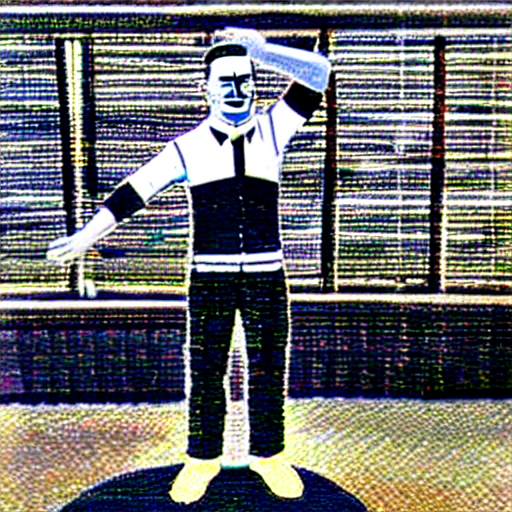

In [42]:
Image.fromarray((res.videos[0].permute(1, 2, 3, 0).squeeze(0).cpu().numpy() * 255).astype(np.uint8))

In [ ]:
# controlnet = UNet2DConditionModel.from_config("../../diffusers_controlnet/models/control_sd15_openpose/controlnet/config.json")
controlnet = UNet2DConditionModel.from_pretrained("../../diffusers_controlnet/models/control_sd15_openpose/controlnet")

In [ ]:
x = torch.randn(1, 4, 64, 64)
t = 1
encoder_hidden_states = torch.randn(1, 320, 768)
hint = torch.randn(1, 3, 512, 512)
res = controlnet(x, t, encoder_hidden_states=encoder_hidden_states, controlnet_hint=hint)

In [ ]:
len(res)

In [ ]:
path = "../checkpoints/tav_yor_dedede/unet"
# unet = UNet3DConditionModel.from_pretrained(path, torch_dtype=torch.float)
unet = UNet3DConditionModel.from_config(path + "/config.json")

In [ ]:
"""
control = [
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 640, 1, 16, 16),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 320, 1, 32, 32),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
]
"""
control = [
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 64, 64),
    torch.randn(1, 320, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 32, 32),
    torch.randn(1, 640, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 16, 16),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
    torch.randn(1, 1280, 1, 8, 8),
]

In [ ]:
sample = torch.randn(1, 4, 1, 64, 64)
timestep = 1
encoder_hidden_states = torch.randn(1, 320, 768)
res = unet(sample, timestep, encoder_hidden_states, control = control)

In [ ]:
res.sample.shape